# Vacancy formation energy and volume from implicit derivative

In [1]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy.interpolate import CubicSpline

# Local imports
from lammps_implicit_der import LammpsImplicitDer, SNAP
from lammps_implicit_der.tools import mpi_print, initialize_mpi, TimingGroup, plot_tools, \
                                      compute_energy_volume, create_perturbed_system, run_npt_implicit_derivative
from lammps_implicit_der.tools.error_tools import coord_error
from lammps_implicit_der.systems import BccVacancy, Bcc
#from lammps_implicit_der.tools.error_tools import coord_error

plotparams = plot_tools.plotparams.copy()
plotparams['figure.figsize'] = (9, 6)
plotparams['font.size'] = 16
plotparams['figure.subplot.wspace'] = 0.2
plt.rcParams.update(plotparams)

# Create the W bcc pure and vacancy systems

In [2]:
ncell_x = 2
alat = 3.18427
alat_vac = 3.163

bcc_pure = Bcc(alat=alat, ncell_x=ncell_x, minimize=True, logname='bcc.log',
               data_path = '../lammps_implicit_der/data_files/', snapcoeff_filename = 'W_NEW.snapcoeff', verbose=False)

bcc_vac = BccVacancy(alat=alat_vac, ncell_x=ncell_x, minimize=True, logname='bcc_vac.log',
                     data_path = '../lammps_implicit_der/data_files/', snapcoeff_filename = 'W_NEW.snapcoeff', verbose=False)

print(f'{bcc_pure.Natom=}')
print(f'{bcc_pure.energy=:.3f}')
print(f'{bcc_vac.Natom=}')
print(f'{bcc_vac.energy=:.3f}')

bcc_pure.Natom=16
bcc_pure.energy=-89.061
bcc_vac.Natom=15
bcc_vac.energy=-80.365


## Energy-volume curve

In [3]:
epsilon_array = np.linspace(-0.05, 0.05, 61)
bcc_pure_tmp = Bcc(alat=alat, ncell_x=ncell_x, minimize=True, logname='bcc.log',
               data_path = '../lammps_implicit_der/data_files/', snapcoeff_filename = 'W_NEW.snapcoeff', verbose=False)

bcc_vac_tmp = BccVacancy(alat=alat_vac, ncell_x=ncell_x, minimize=True, logname='bcc_vac.log',
                     data_path = '../lammps_implicit_der/data_files/', snapcoeff_filename = 'W_NEW.snapcoeff', verbose=False)

energy_array_pure, volume_array_pure, virial_array_pure, pressure_array_pure = compute_energy_volume(bcc_pure_tmp, epsilon_array)
energy_array_vac, volume_array_vac, virial_array_vac, pressure_array_vac = compute_energy_volume(bcc_vac_tmp, epsilon_array)

In [4]:
def get_min(energy_array, volume_array, pressure_array, ncell_x):
    min_idx = np.argmin(energy_array)

    energy_min = energy_array[min_idx]
    volume_min = volume_array[min_idx]
    pressure_min = pressure_array[min_idx]

    alat_min = volume_min**(1/3) / ncell_x

    return energy_min, volume_min, pressure_min, alat_min

energy_pure_min, volume_pure_min, pressure_pure_min, alat_pure_min = \
    get_min(energy_array_pure, volume_array_pure, pressure_array_pure, ncell_x)

print('Pure bcc:')
print(f'{energy_pure_min=:.3f}')
print(f'{volume_pure_min=:.3f}')
print(f'{pressure_pure_min=:.3f}')
print(f'{alat_pure_min=:.3f}')
print('')

energy_vac_min, volume_vac_min, pressure_vac_min, alat_vac_min = \
    get_min(energy_array_vac, volume_array_vac, pressure_array_vac, ncell_x)

print('Vacancy bcc:')
print(f'{energy_vac_min=:.3f}')
print(f'{volume_vac_min=:.3f}')
print(f'{pressure_vac_min=:.3f}')
print(f'{alat_vac_min=:.3f}')

Pure bcc:
energy_pure_min=0.000
volume_pure_min=258.297
pressure_pure_min=-0.003
alat_pure_min=3.184

Vacancy bcc:
energy_vac_min=0.000
volume_vac_min=253.156
pressure_vac_min=0.081
alat_vac_min=3.163


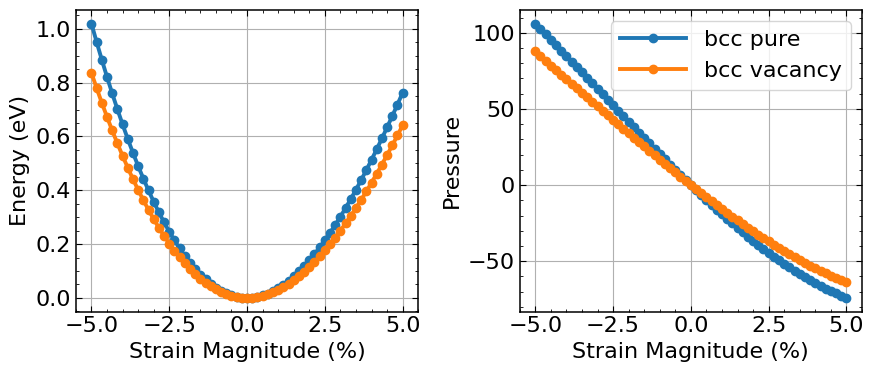

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

ms = 6
axes[0].plot(100.0 * epsilon_array, energy_array_pure, label='bcc pure', ls='-', marker='o', ms=ms)
axes[0].plot(100.0 * epsilon_array, energy_array_vac, label='bcc vacancy', ls='-', marker='o', ms=ms)
axes[0].set_xlabel('Strain Magnitude (%)')
axes[0].set_ylabel('Energy (eV)')

axes[1].plot(100.0 * epsilon_array, pressure_array_pure, label='bcc pure', ls='-', marker='o', ms=ms)
axes[1].plot(100.0 * epsilon_array, pressure_array_vac, label='bcc vacancy', ls='-', marker='o', ms=ms)
axes[1].set_xlabel('Strain Magnitude (%)')
axes[1].set_ylabel('Pressure')
axes[1].legend()

for ax in axes:
    ax.grid()

plt.tight_layout()
plt.show()

## Interpolation of virial and its derivative

In [6]:
spline_list_pure = []
spline_list_vac = []

for idesc in range(bcc_pure.Ndesc):

    virial_trace_array_pure = np.sum(virial_array_pure[:, :3, :], axis=1) / 3.0
    spline_list_pure.append(CubicSpline(volume_array_pure, virial_trace_array_pure[:, idesc]))

    virial_trace_array_vac = np.sum(virial_array_vac[:, :3, :], axis=1) / 3.0
    spline_list_vac.append(CubicSpline(volume_array_vac, virial_trace_array_vac[:, idesc]))

virial_der_pure0 = np.array([spline_list_pure[idesc](volume_pure_min, nu=1) for idesc in range(bcc_pure.Ndesc)])
virial_der_vac0 = np.array([spline_list_vac[idesc](volume_vac_min, nu=1) for idesc in range(bcc_vac.Ndesc)])

# Perturb parameters and compute formation volumes and energies

### Implicit derivative - inhomogeneous contribution

In [7]:
# Re-define the same systems
bcc_pure = Bcc(alat=alat, ncell_x=ncell_x, minimize=True, logname='bcc.log',
               data_path = '../lammps_implicit_der/data_files/', snapcoeff_filename = 'W_NEW.snapcoeff', verbose=False)

bcc_vac = BccVacancy(alat=alat_vac, ncell_x=ncell_x, minimize=True, logname='bcc_vac.log',
                     data_path = '../lammps_implicit_der/data_files/', snapcoeff_filename = 'W_NEW.snapcoeff', verbose=False)

dX_dTheta_pure_inhom = bcc_pure.implicit_derivative(method='inverse')
dX_dTheta_vac_inhom = bcc_vac.implicit_derivative(method='inverse')

bcc_pure.compute_virial()
bcc_pure.gather_virial()
virial_pure = np.sum(bcc_pure.virial, axis=0)
virial_trace_pure = np.sum(virial_pure[:3, :], axis=0) / 3.0

bcc_vac.compute_virial()
bcc_vac.gather_virial()
virial_vac = np.sum(bcc_vac.virial, axis=0)
virial_trace_vac = np.sum(virial_vac[:3, :], axis=0) / 3.0

### Ensemble of Tungsten potentials

In [8]:
path = '../lammps_implicit_der/data_files/'
filename = 'Theta_ens.pkl'
with open(os.path.join(path, filename), 'rb') as file:
    Theta_ens = pickle.load(file)

In [9]:
sample = 1
data_path = '../lammps_implicit_der/data_files/'
snapcoeff_filename = 'W_NEW.snapcoeff'
snapparam_filename ='W_NEW.snapparam'

#delta_array = np.linspace(-20.0, 20.0, 5)
delta_array = np.array([-25.0, -10.0, 0.0, 10.0, 25.0, 50.0, 100.0])
ndelta = len(delta_array)

bcc_pure_list = []
bcc_vac_list = []

for i, delta in enumerate(delta_array):
    print('\n'+'*'*80)
    print(f'{i+1}/{len(delta_array)}, {delta=:.1f}')
    #print('Pure:')
    bcc_pure_list.append(run_npt_implicit_derivative(Bcc, alat, ncell_x, Theta_ens, delta, sample,
                                                     data_path, snapcoeff_filename, snapparam_filename,
                                                     virial_trace_pure, virial_der_pure0,
                                                     dX_dTheta_pure_inhom, dX_dTheta_full=None))

    #print('Vacancy:')
    bcc_vac_list.append(run_npt_implicit_derivative(BccVacancy, alat_vac, ncell_x, Theta_ens, delta, sample,
                                                    data_path, snapcoeff_filename, snapparam_filename,
                                                    virial_trace_vac, virial_der_vac0,
                                                    dX_dTheta_vac_inhom, dX_dTheta_full=None))


********************************************************************************
1/7, delta=-25.0

********************************************************************************
2/7, delta=-10.0

********************************************************************************
3/7, delta=0.0

********************************************************************************
4/7, delta=10.0

********************************************************************************
5/7, delta=25.0

********************************************************************************
6/7, delta=50.0

********************************************************************************
7/7, delta=100.0


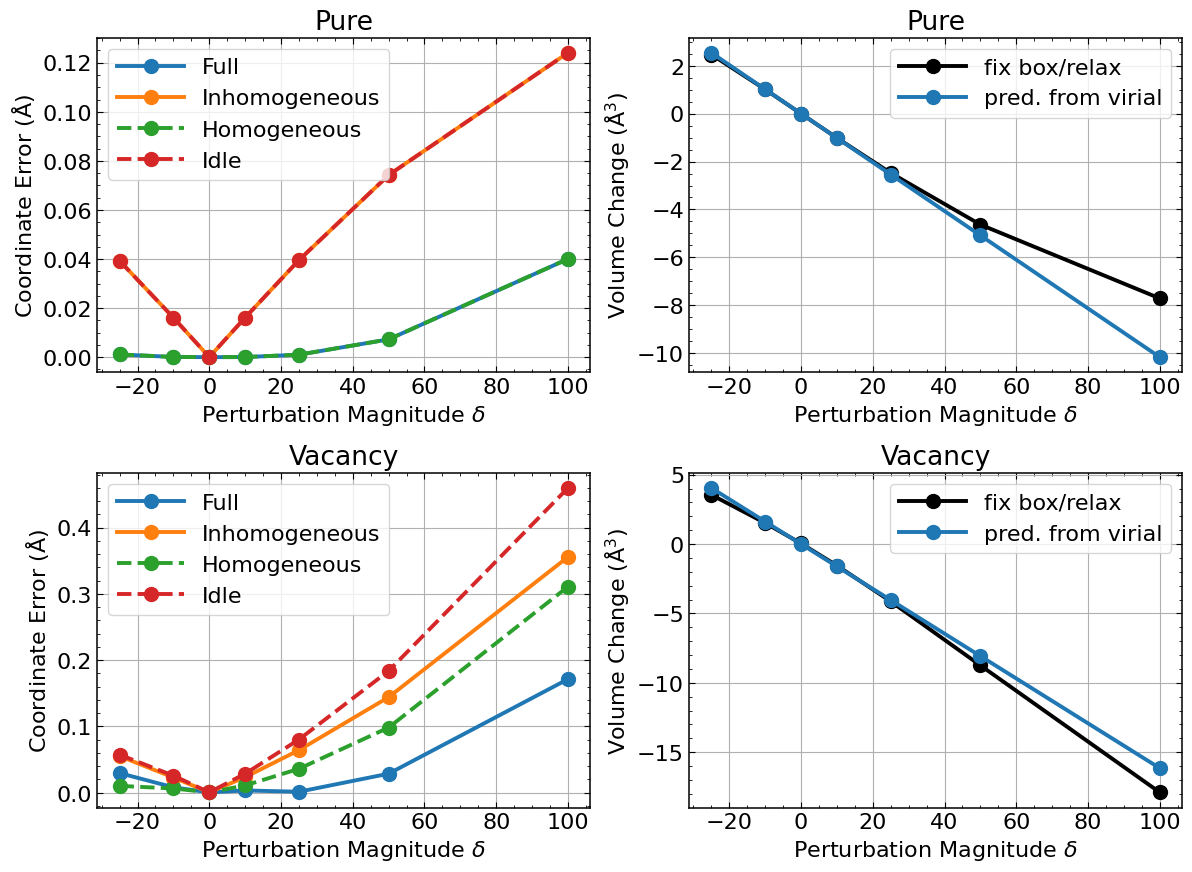

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

plt.subplots_adjust(wspace=0.2, hspace=0.3)

error_axes = [axes[0, 0], axes[1, 0]]
data_lists = [bcc_pure_list, bcc_vac_list]
title_list = ['Pure', 'Vacancy']

for i, (data_list, ax) in enumerate(zip(data_lists, error_axes)):

    ax.plot(delta_array,
            [data_list[i]['coord_error_full'] for i in range(ndelta)],
            label='Full', marker='o')
    ax.plot(delta_array,
            [data_list[i]['coord_error_inhom'] for i in range(ndelta)],
            label='Inhomogeneous', marker='o')
    ax.plot(delta_array,
            [data_list[i]['coord_error_hom'] for i in range(ndelta)],
            label='Homogeneous', marker='o', ls='--')
    ax.plot(delta_array,
            [data_list[i]['coord_error_idle'] for i in range(ndelta)],
            label='Idle', ls='--', marker='o')

    ax.set_xlabel('Perturbation Magnitude $\delta$')
    ax.set_ylabel('Coordinate Error ($\mathrm{\AA}$)')
    ax.grid()
    ax.legend()

    ax.set_title(title_list[i])

vol_axes = [axes[0, 1], axes[1, 1]]

for i, (data_list, ax) in enumerate(zip(data_lists, vol_axes)):

    vol0 = data_list[i]['volume0']
    ax.plot(delta_array,
            [data_list[i]['volume_true'] - vol0 for i in range(ndelta)],
            label='fix box/relax', marker='o', c='black')
    ax.plot(delta_array,
            [data_list[i]['volume_pred'] - vol0 for i in range(ndelta)],
            label='pred. from virial', marker='o', c='tab:blue')

    ax.set_xlabel('Perturbation Magnitude $\delta$')
    ax.set_ylabel('Volume Change ($\mathrm{\AA}^3$)')
    ax.grid()
    ax.legend()

    ax.set_title(title_list[i])

plt.show()

## Compute the energy-volume data

In [11]:
#delta_array_en_vol = np.linspace(-100, 100, 21)
#epsilon_array_en_vol = np.linspace(-0.05, 0.05, 21)

delta_array_en_vol = np.linspace(-100, 100, 3)
epsilon_array_en_vol = np.linspace(-0.05, 0.05, 3)

data_path = '../lammps_implicit_der/data_files/'
snapcoeff_filename = 'W_NEW.snapcoeff'
snapparam_filename ='W_NEW.snapparam'
sample = 1

en_vol_pure_dict = {}
en_vol_vac_dict = {}

en_vol_pure_dict['epsilon_array'] = epsilon_array_en_vol
en_vol_vac_dict['epsilon_array'] = epsilon_array_en_vol

for i, delta in enumerate(delta_array_en_vol):
    print(f'{i+1:02d}/{len(delta_array_en_vol)}, {delta=:.2f}')
    bcc_vac_tmp = create_perturbed_system(Theta_ens, delta, BccVacancy, logname='vac_tmp.log',
                                          data_path=data_path, snapcoeff_filename=snapcoeff_filename, snapparam_filename=snapparam_filename,
                                          sample=sample, alat=alat_vac, ncell_x=ncell_x, fix_box_relax=False, minimize=True, verbose=False)

    bcc_pure_tmp = create_perturbed_system(Theta_ens, delta, Bcc, logname='vac_tmp.log',
                                        data_path=data_path, snapcoeff_filename=snapcoeff_filename, snapparam_filename=snapparam_filename,
                                        sample=sample, alat=alat, ncell_x=ncell_x, fix_box_relax=False, minimize=True, verbose=False)

    energy_array_pure, volume_array_pure, virial_array_pure, pressure_array_pure = compute_energy_volume(bcc_pure_tmp, epsilon_array_en_vol)
    energy_array_vac, volume_array_vac, virial_array_vac, pressure_array_vac = compute_energy_volume(bcc_vac_tmp, epsilon_array_en_vol)

    en_vol_pure_dict[f'delta_{delta:06.2f}'] = {'energy_array': energy_array_pure, 'volume_array': volume_array_pure, 'pressure_array': volume_array_pure}
    en_vol_vac_dict[f'delta_{delta:06.2f}'] = {'energy_array': energy_array_vac, 'volume_array': volume_array_vac, 'pressure_array': volume_array_vac}

01/3, delta=-100.00
02/3, delta=0.00
03/3, delta=100.00


In [12]:
def compute_formation_property(Natom_vac, Natom_pure, vac_list, pure_list, property_name):

    ndelta = len(vac_list)
    prop_pure = np.array([pure_list[i][property_name] for i in range(ndelta)])
    prop_vac = np.array([vac_list[i][property_name] for i in range(ndelta)])
    #print(f'{prop_vac=} {prop_pure=} {Natom_vac=} {Natom_pure=}')
    prop_formation = prop_vac - prop_pure * Natom_vac / Natom_pure

    return prop_formation

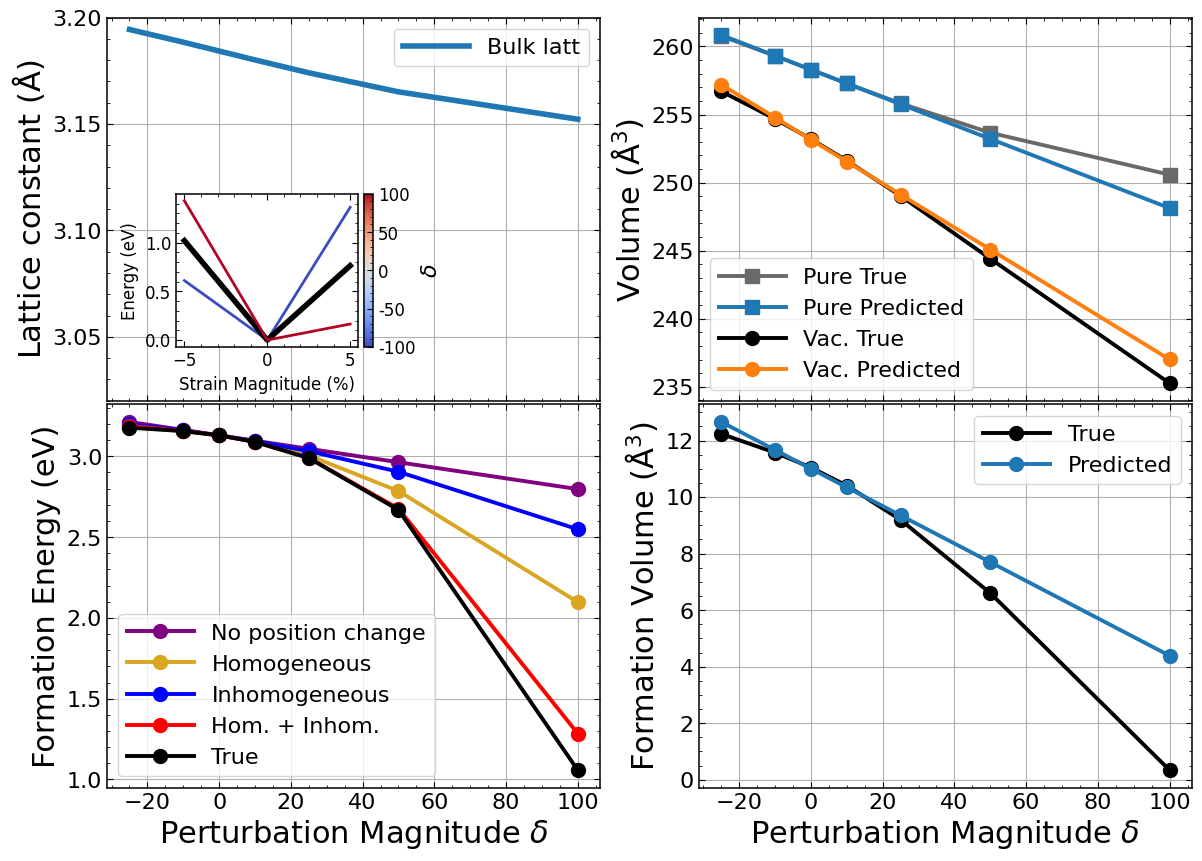

In [15]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
# ticklabel format
from matplotlib.ticker import FormatStrFormatter, MultipleLocator

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

fsize = 22

plt.subplots_adjust(wspace=0.2, hspace=0.01)

# Lattice constant

delta_min, delta_max = -40.0, 105.0

axes[0, 0].plot(delta_array,
            [bcc_pure_list[i]['volume_true']**(1/3) / ncell_x for i in range(ndelta)], lw=4.0, label='Bulk latt')

#axes[0, 0].plot(delta_array,
#            [bcc_vac_list[i]['volume_true']**(1/3) / ncell_x for i in range(ndelta)], lw=4.0, label='Vacancy')

# Create an inset in axes[0, 0] with energy-volume curves
ax_inset = axes[0, 0].inset_axes([0.14, 0.14, 0.4, 0.4])
cmap = plt.get_cmap('coolwarm')
color_array = cmap(np.linspace(0, 1, len(epsilon_array_en_vol)))
epsilon_array = en_vol_pure_dict['epsilon_array']
for i, delta in enumerate(delta_array_en_vol):
    energy_array_pure = en_vol_pure_dict[f'delta_{delta:06.2f}']['energy_array']
    energy_array_vac = en_vol_vac_dict[f'delta_{delta:06.2f}']['energy_array']

    if abs(delta) < 1e-6:
        color = 'black'
        lw = 4.0
    else:
        lw = 2.0
        color = color_array[i]

    ax_inset.plot(100.0 * epsilon_array, energy_array_pure, c=color, lw=lw)

fsize_inset = 12
# Colorbar for inset
#cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=ax_inset, orientation='vertical')
divider = make_axes_locatable(ax_inset)
cax = divider.append_axes('right', size='5%', pad=0.05)
norm = plt.Normalize(vmin=delta_array_en_vol[0], vmax=delta_array_en_vol[-1])
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), cax=cax, orientation='vertical',format='%.0f')
cbar.set_label('$\delta$')
# Fontsize for colorbar
cbar.ax.tick_params(labelsize=fsize_inset)

ax_inset.set_xlabel('Strain Magnitude (%)', fontsize=fsize_inset)
ax_inset.set_ylabel('Energy (eV)', fontsize=fsize_inset)

# Ticklabel size for inset
ax_inset.tick_params(axis='both', which='major', labelsize=fsize_inset)

#axes[0, 0].set_xlabel('Perturbation Magnitude $\delta$')
# remove tick labels
axes[0, 0].set_xticklabels([])
axes[0, 0].set_ylabel('Lattice constant ($\mathrm{\AA}$)', fontsize=fsize)
axes[0, 0].set_ylim(3.02, 3.2)
axes[0, 0].yaxis.set_major_locator(MultipleLocator(0.05))

# Formation energies
Natom_pure = bcc_pure.Natom
Natom_vac = bcc_vac.Natom
E_form_full_pred = compute_formation_property(Natom_vac, Natom_pure, bcc_vac_list, bcc_pure_list, 'energy_full_pred')
E_form_hom_pred = compute_formation_property(Natom_vac, Natom_pure, bcc_vac_list, bcc_pure_list, 'energy_hom_pred')
E_form_inhom_pred = compute_formation_property(Natom_vac, Natom_pure, bcc_vac_list, bcc_pure_list, 'energy_inhom_pred')
E_form_true = compute_formation_property(Natom_vac, Natom_pure, bcc_vac_list, bcc_pure_list, 'energy_true')
E_form_pred0 = compute_formation_property(Natom_vac, Natom_pure, bcc_vac_list, bcc_pure_list, 'energy_pred0')

axes[1, 0].plot(delta_array, E_form_pred0, label='No position change', marker='o', c='purple')
axes[1, 0].plot(delta_array, E_form_hom_pred, label='Homogeneous', marker='o', c='goldenrod')
axes[1, 0].plot(delta_array, E_form_inhom_pred, label='Inhomogeneous', marker='o', c='blue')
axes[1, 0].plot(delta_array, E_form_full_pred, label='Hom. + Inhom.', marker='o', c='red')
axes[1, 0].plot(delta_array, E_form_true, label='True', marker='o', c='black')


axes[1, 0].set_xlabel('Perturbation Magnitude $\delta$', fontsize=fsize)
axes[1, 0].set_ylabel('Formation Energy (eV)', fontsize=fsize)

# Absolute volume
axes[0, 1].plot(delta_array,
          [bcc_pure_list[i]['volume_true'] for i in range(ndelta)],
          label='Pure True', marker='s', c='dimgray')

axes[0, 1].plot(delta_array,
          [bcc_pure_list[i]['volume_pred'] for i in range(ndelta)],
          label='Pure Predicted', marker='s')

axes[0, 1].plot(delta_array,
          [bcc_vac_list[i]['volume_true'] for i in range(ndelta)],
          label='Vac. True', marker='o', c='black')

axes[0, 1].plot(delta_array,
          [bcc_vac_list[i]['volume_pred'] for i in range(ndelta)],
          label='Vac. Predicted', marker='o')

axes[0, 1].set_xticklabels([])
axes[0, 1].set_ylabel('Volume ($\mathrm{\AA}^3$)', fontsize=fsize)

# Formation volume
vol_form_full_pred = compute_formation_property(Natom_vac, Natom_pure, bcc_vac_list, bcc_pure_list, 'volume_pred')
vol_form_true = compute_formation_property(Natom_vac, Natom_pure, bcc_vac_list, bcc_pure_list, 'volume_true')

axes[1, 1].plot(delta_array, vol_form_true, label='True', marker='o', c='black')
axes[1, 1].plot(delta_array, vol_form_full_pred, label='Predicted', marker='o')

axes[1, 1].set_xlabel('Perturbation Magnitude $\delta$', fontsize=fsize)
axes[1, 1].set_ylabel('Formation Volume ($\mathrm{\AA}^3$)', fontsize=fsize)

for ax in axes.flatten():
    ax.grid()
    ax.legend()
    #ax.set_xlim(delta_min, delta_max)

axes[0,0].legend(loc='upper right')
fig.savefig('formation_energy_2x2.pdf')

plt.show()

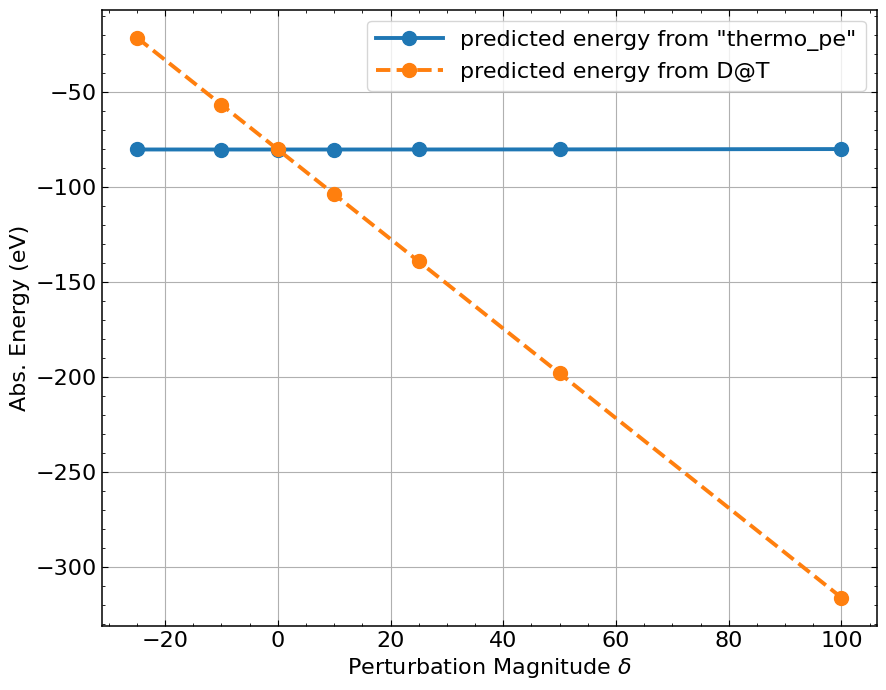

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

plt.subplots_adjust(wspace=0.2, hspace=0.01)

# Absolute energy

ax.plot(delta_array, [bcc_vac_list[i]['energy_inhom_pred3'] for i in range(ndelta)], label='predicted energy from "thermo_pe"', marker='o')
ax.plot(delta_array, [bcc_vac_list[i]['energy_inhom_pred2'] for i in range(ndelta)], label='predicted energy from D@T', marker='o', ls='--')

ax.set_xlabel('Perturbation Magnitude $\delta$')
ax.set_ylabel('Abs. Energy (eV)')

ax.grid()
ax.legend()

plt.show()

In [ ]:
system_tmp = BccVacancy(alat=alat_vac, ncell_x=ncell_x, minimize=True, logname='bcc_vac.log',
                        data_path = '../lammps_implicit_der/data_files/', snapcoeff_filename = 'W_NEW.snapcoeff', verbose=False)
print(system_tmp.energy)
print(np.ctypeslib.as_array(system_tmp.lmp.gather("c_E", 1, 1)).sum())
system_tmp.pot.snapcoeff_path = 'W_perturb.snapcoeff'
system_tmp.pot.snapparam_path = 'W_perturb.snapparam'
system_tmp.setup_snap_potential()
print(system_tmp.energy)

-80.36527467896518
-80.36527467896518
517.1064863093175
